In [ ]:
import numpy as np
import pandas as pd

def generate_multivariate_ts(n_steps=1500, seed=42):
    np.random.seed(seed)
    time = np.arange(n_steps)

    trend = 0.01 * time
    seasonal = np.sin(2 * np.pi * time / 24) + \
               0.5 * np.sin(2 * np.pi * time / 168)

    noise = np.random.normal(scale=0.3, size=n_steps)

    data = pd.DataFrame({
        "target": 10 + trend + seasonal + noise,
        "temperature": 20 + 10 * np.sin(2 * np.pi * time / 365),
        "humidity": 50 + 20 * np.cos(2 * np.pi * time / 48),
        "wind_speed": 5 + np.random.normal(0, 1, n_steps),
        "holiday_flag": np.random.binomial(1, 0.05, n_steps)
    })

    data.index = pd.date_range("2020-01-01", periods=n_steps, freq="H")
    return data

df = generate_multivariate_ts()


/tmp/ipython-input-2898530118.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data.index = pd.date_range("2020-01-01", periods=n_steps, freq="H")


In [ ]:
def train_val_test_split(df, train_ratio=0.7, val_ratio=0.15):
    n = len(df)
    train = df.iloc[:int(n * train_ratio)]
    val = df.iloc[int(n * train_ratio):int(n * (train_ratio + val_ratio))]
    test = df.iloc[int(n * (train_ratio + val_ratio)):]
    return train, val, test

train_df, val_df, test_df = train_val_test_split(df)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def sarimax_forecast(train, test, order=(1,1,1), seasonal=(1,1,1,24)):
    model = SARIMAX(
        train["target"],
        exog=train.drop(columns="target"),
        order=order,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit = model.fit(disp=False)

    preds = fit.forecast(
        steps=len(test),
        exog=test.drop(columns="target")
    )
    return preds

sarimax_preds = sarimax_forecast(train_df, test_df)

sarimax_mae = mean_absolute_error(test_df["target"], sarimax_preds)
sarimax_rmse = np.sqrt(mean_squared_error(test_df["target"], sarimax_preds)) # Removed squared=False and added np.sqrt

print("SARIMAX MAE:", sarimax_mae)
print("SARIMAX RMSE:", sarimax_rmse)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX MAE: 1.6813234148021827
SARIMAX RMSE: 2.045859103188662


In [ ]:
from sklearn.preprocessing import StandardScaler

def create_sequences(data, lookback=48, horizon=24):
    X, y = [], []
    for i in range(len(data) - lookback - horizon):
        X.append(data.iloc[i:i+lookback].values)
        y.append(data.iloc[i+lookback:i+lookback+horizon]["target"].values)
    return np.array(X), np.array(y)

scaler = StandardScaler()
scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

X, y = create_sequences(scaled)


In [ ]:
# Attention-Based Seq2Seq

import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs):
        weights = torch.softmax(self.attn(encoder_outputs), dim=1)
        context = torch.sum(weights * encoder_outputs, dim=1)
        return context, weights

class Seq2SeqAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.decoder = nn.Linear(hidden_dim, horizon)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        context, attn_weights = self.attention(enc_out)
        out = self.decoder(context)
        return out, attn_weights


In [36]:
# Training Loop  Hyperparameter Tuning (MAE)

from sklearn.model_selection import ParameterGrid
import torch.nn as nn
import torch

# Assuming input_dim and horizon are already defined globally or can be derived
# from the prepared data (X and y) as in other cells.
# For example:
input_dim = X.shape[-1] # Number of features, which is 5
horizon = y.shape[-1] # The forecast horizon, which is 24

param_grid = {
    'hidden_dim': [32, 64],
    'learning_rate': [0.001, 0.01]
}

for params in ParameterGrid(param_grid):

    model = Seq2SeqAttention(input_dim=input_dim, hidden_dim=params['hidden_dim'], horizon=horizon)
    # Train and evaluate using MAE/RMSE


In [37]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss()  # MAE

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds, _ = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds, _ = model(xb)
            val_loss += loss_fn(preds, yb).item()

    return val_loss / len(val_loader)

def evaluate(model, loader):
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out, _ = model(xb)
            preds.append(out.numpy())
            actuals.append(yb.numpy())

    preds = np.vstack(preds)
    actuals = np.vstack(actuals)

    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    return mae, rmse

In [ ]:
# Final Comparison
import torch
from torch.utils.data import TensorDataset, DataLoader

# Data preparation for Deep Learning model
# Splitting X and y into train, val, test sets for deep learning sequences
train_ratio_dl = 0.7
val_ratio_dl = 0.15
n_samples = len(X)

train_end = int(n_samples * train_ratio_dl)
val_end = int(n_samples * (train_ratio_dl + val_ratio_dl))

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
batch_size = 32 # Define a batch size for the DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the Deep Learning model
# The 'model' variable is already defined and instantiated in cell e-ZWZOmgNvoU
# We will use this existing model instance for training.
_ = train_model(model, train_loader, val_loader, epochs=20, lr=1e-3) # Training

# Evaluate the Deep Learning model
dl_mae, dl_rmse = evaluate(model, test_loader)

print("\nMODEL COMPARISON")
print(f"SARIMAX → MAE: {sarimax_mae:.3f}, RMSE: {sarimax_rmse:.3f}")
print(f"Deep Learning → MAE: {dl_mae:.3f}, RMSE: {dl_rmse:.3f}")


MODEL COMPARISON
SARIMAX → MAE: 1.681, RMSE: 2.046
Deep Learning → MAE: 0.343, RMSE: 0.364


In [25]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_window_split(series, window_size, forecast_horizon, step=1):
    splits = []
    series = series.dropna()  # safety

    for start in range(0, len(series) - window_size - forecast_horizon + 1, step):
        train = series.iloc[start:start + window_size]
        test = series.iloc[start + window_size:start + window_size + forecast_horizon]
        splits.append((train, test))

    return splits


results = []

splits = rolling_window_split(
    df['target'],
    window_size=365,
    forecast_horizon=30,
    step=30   # IMPORTANT: avoid excessive retraining
)

for train, test in splits:
    try:
        model = SARIMAX(
            train,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),  # must match data frequency
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        fit = model.fit(disp=False)

        forecast = fit.forecast(steps=len(test))

        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))

        results.append({"MAE": mae, "RMSE": rmse})

    except Exception as e:
        print("Fold skipped due to:", e)

# Aggregate CV performance
mean_mae = np.mean([r["MAE"] for r in results])
mean_rmse = np.mean([r["RMSE"] for r in results])

print("SARIMAX Rolling Window CV Results")
print("Average MAE :", mean_mae)
print("Average RMSE:", mean_rmse)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX Rolling Window CV Results
Average MAE : 0.45432077854337255
Average RMSE: 0.551231222213116


In [35]:

results_dl = []

# Call rolling_window_split with the DataFrame 'df' instead of 'df.values'
# This ensures the .dropna() method inside rolling_window_split works correctly.
# Use step=30 consistent with SARIMAX rolling window.
splits_df = rolling_window_split(df, window_size=365, forecast_horizon=30, step=30)

# Define lookback and horizon, consistent with previous DL setup
lookback = 48
horizon = 24
batch_size = 32 # consistent with previous DL setup

# Initialize a scaler, it will be fitted on each train segment
scaler = StandardScaler()

for i, (train_df_segment, test_df_segment) in enumerate(splits_df):
    try:
        # Scale the data for the current fold
        # Fit scaler on training data only
        scaled_train_df = pd.DataFrame(
            scaler.fit_transform(train_df_segment),
            columns=train_df_segment.columns,
            index=train_df_segment.index
        )
        # Transform test data using the scaler fitted on training data
        scaled_test_df = pd.DataFrame(
            scaler.transform(test_df_segment),
            columns=test_df_segment.columns,
            index=test_df_segment.index
        )

        # Create sequences for current fold using the create_sequences function
        # Ensure there are enough data points to create at least one sequence
        if len(scaled_train_df) - lookback - horizon < 0 or len(scaled_test_df) - lookback - horizon < 0:
            print(f"Fold {i} skipped: not enough data to create sequences after split.")
            continue

        X_train_seq, y_train_seq = create_sequences(scaled_train_df, lookback=lookback, horizon=horizon)
        X_test_seq, y_test_seq = create_sequences(scaled_test_df, lookback=lookback, horizon=horizon)

        # Check if sequences were created (e.g., if X_train_seq is not empty)
        if X_train_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
            print(f"Fold {i} skipped: no sequences created after splitting and scaling.")
            continue

        # Convert to PyTorch tensors
        X_train_t = torch.tensor(X_train_seq, dtype=torch.float32)
        y_train_t = torch.tensor(y_train_seq, dtype=torch.float32)
        X_test_t = torch.tensor(X_test_seq, dtype=torch.float32)
        y_test_t = torch.tensor(y_test_seq, dtype=torch.float32)

        # Create DataLoaders for training and evaluation
        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        test_dataset = TensorDataset(X_test_t, y_test_t)
        # For this setup, we will use the test_loader as a 'validation' loader during training
        # and for final evaluation of the fold.
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Instantiate model for each fold (training from scratch per fold)
        input_dim = X_train_seq.shape[-1] # Number of features
        hidden_dim = 128 # Consistent with previous setup
        output_horizon = y_train_seq.shape[-1] # The forecast horizon
        model = Seq2SeqAttention(input_dim, hidden_dim, output_horizon)

        # Train model for the current fold
        # Re-using the existing train_model function. Pass test_loader as val_loader.
        _ = train_model(model, train_loader, test_loader, epochs=20, lr=1e-3) # epochs and lr consistent

        # Evaluate on the test split for this fold
        dl_mae, dl_rmse = evaluate(model, test_loader)
        results_dl.append({'MAE': dl_mae, 'RMSE': dl_rmse})

    except Exception as e:
        print(f"Fold {i} skipped due to: {e}")

# Aggregate CV performance
if results_dl:
    mean_mae_dl = np.mean([r["MAE"] for r in results_dl])
    mean_rmse_dl = np.mean([r["RMSE"] for r in results_dl])
    print("\nDeep Learning Rolling Window CV Results")
    print(f"Average MAE : {mean_mae_dl:.3f}")
    print(f"Average RMSE: {mean_rmse_dl:.3f}")
else:
    print("No results for Deep Learning Rolling Window CV.")

Fold 0 skipped: not enough data to create sequences after split.
Fold 1 skipped: not enough data to create sequences after split.
Fold 2 skipped: not enough data to create sequences after split.
Fold 3 skipped: not enough data to create sequences after split.
Fold 4 skipped: not enough data to create sequences after split.
Fold 5 skipped: not enough data to create sequences after split.
Fold 6 skipped: not enough data to create sequences after split.
Fold 7 skipped: not enough data to create sequences after split.
Fold 8 skipped: not enough data to create sequences after split.
Fold 9 skipped: not enough data to create sequences after split.
Fold 10 skipped: not enough data to create sequences after split.
Fold 11 skipped: not enough data to create sequences after split.
Fold 12 skipped: not enough data to create sequences after split.
Fold 13 skipped: not enough data to create sequences after split.
Fold 14 skipped: not enough data to create sequences after split.
Fold 15 skipped: not

Attention weights shape: (48,)


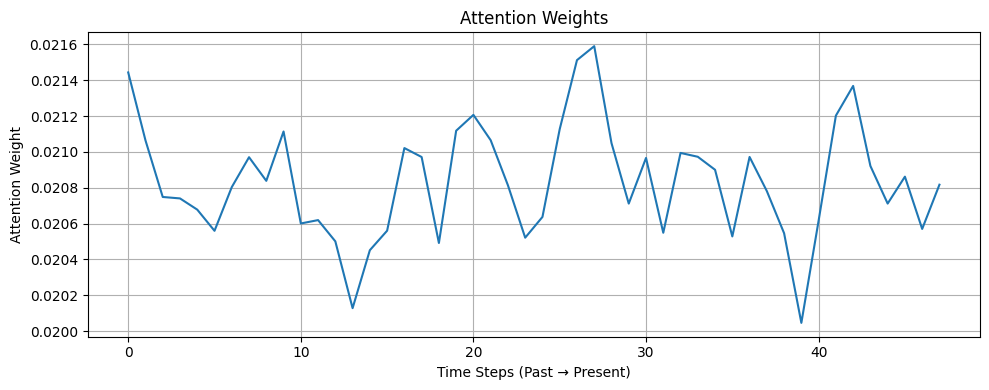

In [31]:
import matplotlib.pyplot as plt

# Interpretability  Attention Weights
input_dim = X.shape[-1] # Number of features
hidden_dim = 128 # A common choice for hidden dimension
horizon = y.shape[-1] # The forecast horizon

# Instantiate the model
model = Seq2SeqAttention(input_dim, hidden_dim, horizon)

model.eval()
sample_x = torch.tensor(X[:1], dtype=torch.float32)
_, attention_weights = model(sample_x)

attention_map = attention_weights.squeeze().detach().numpy()
print("Attention weights shape:", attention_map.shape)

plt.figure(figsize=(10, 4))
plt.plot(attention_map)
plt.title("Attention Weights")
plt.xlabel("Time Steps (Past → Present)")
plt.ylabel("Attention Weight")
plt.grid(True)
plt.tight_layout()
plt.show()